In [1]:
using ADCME
using Plots
using PyCall
#### Read data
py"""
import numpy as np
"""

In [2]:
function f_hi(a, T, R)
        v1 = (a[:,2] + a[:,3] * T + a[:,4] * T^2 + a[:,5] * T^3 + a[:,6] * T^4) * R
        v2 = (a[:,2] + a[:,3] * T / 2 + a[:,4] * T^2 /3 + a[:,5] * T^3 /4 + a[:,6] * T^4 /5 + a[:,7]/T) * R * T
        v3 = (a[:,2] * log(T) + a[:,3] * T + a[:,4] * T^2 /2 + a[:,5] * T^3 /3 + a[:,6] * T^4 / 4 + a[:,8]) * R
    return [v1 v2 v3]
end
 
function f_lo(a, T, R)
    v1 = (a[:,9] + a[:,10] * T + a[:,11] * T^2 + a[:,12] * T^3 + a[:,13] * T^4) * R
    v2 = (a[:,9] + a[:,10] * T / 2 + a[:,11] * T^2 /3 + a[:,12] * T^3 /4 + a[:,13] * T^4 /5 + a[:,14]/T) * R * T
    v3 = (a[:,9] * log(T) + a[:,10] * T + a[:,11] * T^2 /2 + a[:,12] * T^3 /3 + a[:,13] * T^4 / 4 + a[:,15]) * R
    return [v1 v2 v3]
end 

function compute_falloff(T, pr, a)
    fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
    c = -0.4 - 0.67 * log(fcent) / log(10)
    n = 0.75 - 1.27 * log(fcent) / log(10)
    f1 = (log(pr) / log(10) + c) / (n - 0.14 *(log(pr) / log(10) + c))
    return  10 ^ ((log(fcent) / log(10)) / (1 + f1 ^ 2))
end

compute_falloff (generic function with 1 method)

In [3]:
V = 1  # Volume
m = (py"np.load"("data/density.npy"))[1]  # Total mass
tbd = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy") .+ 1
falofr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy") .+ 1
elmr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy") .+ 1
NASA_coeffs = py"np.load"("data/NASA_coeffs.npy")
W = py"np.load"("data/molecular_weights.npy") # Molar weight
ν1 = py"np.load"("data/reactants_stoich_coeffs.npy") # Forward molar stoichiometric coefficients
ν2 = py"np.load"("data/product_stoich_coeffs.npy") # Backward model stoichiometric coefficients
reversible = py"np.load"("data/reversible.npy")
N = size(ν1)[1]  # Number of Species
M = size(ν1)[2]  # Number of Reactions
ν1_order = zeros(N,M)
ν = ν2 - ν1  
pa = 100000 # 1 bar
R = 8314.4621 # Gas constant in kmol
### Constants: Combustion Chamber Level
min_dot = 0 # Rate at which mass enters the chamber
mout_dot = 0 # Rate at which mass leaves the chamber
Yin = ones(N) # Mass fraction of species entering the chamber
Yout = ones(N) # Mass fraction of species leaving the chamber
Qdot = 0 # Heating source
m_dot = min_dot - mout_dot
hin = 1 # Enthalpy of input
### Unknowns
Tt_cant = py"np.load"("data/temperature.npy")
T = Tt_cant[1] # Temperature
Y = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy") # Mass fractions
#Y .+= 0.00001
#Y ./ sum(Y)
### Quantities that depend on the Unknowns
tbd = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy") .+ 1
tbd = Int.(tbd)
falofr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy") .+ 1
falofr = Int.(falofr)
elmr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy") .+ 1
elmr = Int.(elmr)

order = py"np.load"("data/reaction_orders.npy")
Af = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy") # preexponential constant Afj
β = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy") # Temperature exponent
E = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy") # Activation energy for the reactions in kJ

order_t = py"np.load"("data/reaction_orders_t.npy")
efficiency_t = py"np.load"("data/efficiency_t.npy")
Af_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy") # preexponential constant Afj
β_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy") # Temperature exponent
E_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy") # Activation energy for the reactions in kJ

order_f = py"np.load"("data/reaction_orders_f.npy")
troefall = py"np.load"("data/troefall.npy") .+ 1
troefall_coeff = py"np.load"("data/troefall_coeff.npy")
efficiency_f = py"np.load"("data/efficiency_f.npy")
Af_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy") # preexponential constant Afj
β_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy") # Temperature exponent
E_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy") 

Af_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy") # preexponential constant Afj
β_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy") # Temperature exponent
E_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy") 

ν1_order[:,elmr] = order
ν1_order[:,tbd] = order_t
ν1_order[:,falofr] = order_f;

In [4]:
function q(t)
    t0 = 1e-5
    r = 1e-6
    c = 1e12
    return c * exp(-(t-t0)^2 / r^2)
end
function f(TY, Qdot, t)
    T = TY[1]
    Y = TY[2:end]
    ρ = m / V # density
    X = tf.reshape(ρ * tf.divide(Y, W), (N,1)) # Concentration
    Q = ADCME.constant(ones(M)) # Individual progress rates
    islarge = T > ADCME.constant(NASA_coeffs[:,1])
    islarge = convert_to_tensor(islarge, dtype=Float64)
    fhi = f_hi(NASA_coeffs, T, R)
    flo = f_lo(NASA_coeffs, T, R)
    cp = islarge .* fhi[:,1] + (1 - islarge) .* flo[:,1]
    h = islarge .* fhi[:,2] + (1 - islarge) .* flo[:,2]
    s = islarge .* fhi[:,3] + (1 - islarge) .* flo[:,3]
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    ####
    M_t = efficiency_t' * X[:,1]
    Kf_t = Af_t .* (T ^ β_t) .* exp(-E_t / (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) ^ sum(ν[:,tbd], dims=1)')[:,1] .* exp(ΔS[tbd] ./ R - ΔH[tbd] / (R * T)))
    Qtbd =  Kf_t .* (prod(tf.pow(X, order_t), dims=1)) .- Kr_t .* (prod(tf.pow(X, ν2[:,tbd]), dims=1) .* reversible[tbd])
    M_f = efficiency_f' * X[:,1]
    Kf_lo = Af_lo .* (T ^ β_lo) .* exp(-E_lo / (R * T)) .* M_f
    Kf_hi = Af_hi .* (T ^ β_hi) .* exp(-E_hi / (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ADCME.constant(ones(size(falofr)[1]))
    for (i,s) in enumerate(troefall)
        a = troefall_coeff[:,i]
        fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
        c = -0.4 - 0.67 * log(fcent) / log(10)
        n = 0.75 - 1.27 * log(fcent) / log(10)
        f1 = (log(Pr[s]) / log(10) + c) / (n - 0.14 *(log(Pr[s]) / log(10) + c))
        Fac = scatter_update(Fac, troefall[i], 10 ^ ((log(fcent) / log(10)) / (1 + f1 ^ 2)))
    end
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) ^ sum(ν[:,falofr], dims=1)')[:,1] .* exp(ΔS[falofr] ./ R - ΔH[falofr] / (R * T)))
    Qfalofr = Kf_f .* (prod(tf.pow(X, order_f), dims=1)) .- Kr_f .* (prod(tf.pow(X, ν2[:,falofr]), dims=1) .* reversible[falofr])
    ####
#     Af = exp(θ[:,1])
#     β = zeros(M)
#     E = exp(θ[:,3])
    Kf = Af .* (T ^ β) .* exp(-E / (R * T))
    Kr = Kf ./ (((pa/(R * T)) ^ sum(ν[:,elmr], dims=1)')[:,1] .* exp(ΔS[elmr] ./ R - ΔH[elmr] / (R * T)))
    Qelmr = Kf .* (prod(tf.pow(X, order), dims=1)) .- Kr .* (prod(tf.pow(X, ν2[:,elmr]), dims=1) .* reversible[elmr])
    Q = [Qtbd' Qfalofr' Qelmr']
    ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities
    u = h / W - R ./ W * T   # Internal energy for species
    p = sum(X) * R * T # pressure
    ω_dot = W .* sum(ν_new .* Q, dims=2)
    ###### Species Conservation
    mgen_dot = V * ω_dot
    Y_dot = (1 / m) * ((min_dot * (Yin - Y) - mout_dot * Y) + mgen_dot) 
    ###### EnergyConservation
    #Qdot = abs(fc(t * 1e5, [20,20,1], theta[2]) + 1) * 10 ^ theta[1] 
    #Qdot = theta[1] * 1e11 * exp(-(t * 1e5 - theta[2]) ^ 2 / (0.01))
    T_dot = 1 / (m * cv) * (Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
    return tf.concat([tf.reshape(T_dot, (1,)), Y_dot], 0)
end

f (generic function with 1 method)

In [5]:
timestep = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy")
Tt_cant = py"np.load"("data/temperature.npy")
T_ref = zeros(size(timestep)[1])
T_ref[2:end] = Tt_cant
T_ref[1] = 500
Yt_cant = py"np.load"("data/mass_fraction.npy")
Y_ref = [Y Yt_cant]
obs = [T_ref Y_ref']

2001×7 Array{Float64,2}:
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
    ⋮        

In [6]:
Afr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy") # preexponential constant Afj
βr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy") # Temperature exponent
Er = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy") # Activation energy for the reactions in kJ
pr = [log.(Afr) βr log.(Er)]
pr[1,1] = 28.25
pr[2,1] = 17.75
pr[1,3] = 18.75
pr[2,3] = 17.75

17.75

In [7]:
nt = size(timestep)[1]
inds = range(1,2000, step=10)
TY = [T; Y]
function condition(k, U, t)
    k <= nt - 1
end

function body(k, U, t)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    k1 = f(uk, Qdot[k], t[k])
    k2 = f(uk + 0.5 * dt * k1, Qdot[k], t[k] + 0.5 * dt)
    k3 = f(uk + 0.5 * dt * k2, Qdot[k], t[k] + 0.5 * dt)
    k4 = f(uk + dt * k3, Qdot[k], t[k] + dt) 
    u_new = uk + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    U = write(U, k+1, u_new)
    k+1, U, t
end
k = constant(1, dtype=Int32)
t = constant(timestep)
θ = Variable(fc_init([1,20,20,1]))
C = constant(1.7730816960414802)
#theta = Variable([8.0, 0.8])
Qdtb = abs(fc(t * 1e5, [20,20,1], θ))
Qdot = C * 1e6 * Qdtb / sum(Qdtb[1:end-1] * (t[2:end] - t[1:end-1]))
U = TensorArray(nt)
U = write(U, 1, TY)
_, U_out=while_loop(condition, body, [k, U, t])
U_array = set_shape(stack(U_out), (nt, N+1))
loss = sum((U_array[inds,1]-obs[inds,1])^2)
sess = Session()
init(sess)
#u_out = run(sess, U_array)
loss_hist = BFGS!(sess, loss, 1500)
#print(loss_hist)
out = run(sess, U_array)

2020-11-23 21:40:16.051423: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-23 21:40:16.068430: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600030000 Hz
2020-11-23 21:40:16.073089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa2c1d50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-23 21:40:16.073144: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
OMP: Info #156: KMP_AFFINITY: 32 availabl

iter 0, current loss=4.993377140321363e7
iter 1, current loss=3.791402274978085e7
================ STEP 0 ===============
iter 2, current loss=2.944525553848032e7
================ STEP 1 ===============
iter 3, current loss=2.6412545868456833e7
================ STEP 2 ===============
iter 4, current loss=2.564861476696383e7
================ STEP 3 ===============
iter 5, current loss=2.5541454061985724e7
================ STEP 4 ===============
iter 6, current loss=2.53999390950552e7
================ STEP 5 ===============
iter 7, current loss=2.5016447315572698e7
================ STEP 6 ===============
iter 8, current loss=2.3332968269889176e7
iter 9, current loss=2.1336946679849905e8
iter 10, current loss=2.3242307660213485e7
iter 11, current loss=2.3148387957955897e7
iter 12, current loss=2.59878853381361e8
iter 13, current loss=2.2775314896716222e7
iter 14, current loss=2.242106253136382e7
iter 15, current loss=3.3493205271563068e7
iter 16, current loss=2.184255719458881e7
iter 17, 

iter 119, current loss=4.251170894942757e6
================ STEP 77 ===============
iter 120, current loss=4.242959878876468e6
================ STEP 78 ===============
iter 121, current loss=4.141957375656116e6
================ STEP 79 ===============
iter 122, current loss=3.604331956817963e6
================ STEP 80 ===============
iter 123, current loss=3.8197565087508205e6
iter 124, current loss=3.303457285423618e6
================ STEP 81 ===============
iter 125, current loss=3.4566765036568753e6
iter 126, current loss=3.195008495270782e6
================ STEP 82 ===============
iter 127, current loss=3.0967705972087546e6
================ STEP 83 ===============
iter 128, current loss=2.918130804406965e6
================ STEP 84 ===============
iter 129, current loss=2.894180344642508e6
================ STEP 85 ===============
iter 130, current loss=2.7739548530158885e6
================ STEP 86 ===============
iter 131, current loss=2.6953332461230895e6
================ STEP 87 =

iter 227, current loss=420724.65947520646
================ STEP 163 ===============
iter 228, current loss=412921.4096806155
================ STEP 164 ===============
iter 229, current loss=496921.86787903274
iter 230, current loss=408117.0851120603
================ STEP 165 ===============
iter 231, current loss=397637.832607141
================ STEP 166 ===============
iter 232, current loss=380690.64442305476
================ STEP 167 ===============
iter 233, current loss=372846.2594281407
================ STEP 168 ===============
iter 234, current loss=1.8186163442432154e6
iter 235, current loss=370473.00110100117
================ STEP 169 ===============
iter 236, current loss=401980.6526124953
iter 237, current loss=364913.48852854874
================ STEP 170 ===============
iter 238, current loss=348347.1253872837
================ STEP 171 ===============
iter 239, current loss=325711.93165096344
================ STEP 172 ===============
iter 240, current loss=301481.284167064

iter 335, current loss=14265.406576997659
================ STEP 252 ===============
iter 336, current loss=14140.072627102632
================ STEP 253 ===============
iter 337, current loss=14044.194027394904
================ STEP 254 ===============
iter 338, current loss=13871.731950444733
================ STEP 255 ===============
iter 339, current loss=13704.540619677322
================ STEP 256 ===============
iter 340, current loss=13707.371128863735
iter 341, current loss=13662.378047405064
================ STEP 257 ===============
iter 342, current loss=13596.599610553742
================ STEP 258 ===============
iter 343, current loss=14222.398756804903
iter 344, current loss=13308.030628522141
================ STEP 259 ===============
iter 345, current loss=13141.576927412405
iter 346, current loss=13014.897224108165
================ STEP 260 ===============
iter 347, current loss=11852.91832676105
================ STEP 261 ===============
iter 348, current loss=12167.954698

iter 443, current loss=3713.893553356974
================ STEP 341 ===============
iter 444, current loss=3704.164777437102
================ STEP 342 ===============
iter 445, current loss=3692.5277759021583
================ STEP 343 ===============
iter 446, current loss=3679.189209320464
================ STEP 344 ===============
iter 447, current loss=4270.085721924212
iter 448, current loss=3665.891355828623
================ STEP 345 ===============
iter 449, current loss=3643.0628453502413
================ STEP 346 ===============
iter 450, current loss=3637.490345356645
================ STEP 347 ===============
iter 451, current loss=3634.2968495083514
================ STEP 348 ===============
iter 452, current loss=3628.48354192256
================ STEP 349 ===============
iter 453, current loss=3591.6904133832013
================ STEP 350 ===============
iter 454, current loss=3652.348924589756
iter 455, current loss=3583.6418555008604
================ STEP 351 ===============
i

iter 548, current loss=865.7174317590511
iter 549, current loss=858.4117508257132
================ STEP 434 ===============
iter 550, current loss=857.4311153632594
================ STEP 435 ===============
iter 551, current loss=855.6581000648985
================ STEP 436 ===============
iter 552, current loss=853.4546790656029
================ STEP 437 ===============
iter 553, current loss=845.904374091035
================ STEP 438 ===============
iter 554, current loss=1708.8542701693673
iter 555, current loss=843.4111491227932
================ STEP 439 ===============
iter 556, current loss=833.8738923826998
================ STEP 440 ===============
iter 557, current loss=824.1199324653732
================ STEP 441 ===============
iter 558, current loss=829.2235086146504
iter 559, current loss=821.6004482281194
================ STEP 442 ===============
iter 560, current loss=819.136179792348
================ STEP 443 ===============
iter 561, current loss=816.9972714252118
=======

iter 652, current loss=504.5588363906827
================ STEP 528 ===============
iter 653, current loss=496.37021707160903
================ STEP 529 ===============
iter 654, current loss=447.49528253506264
================ STEP 530 ===============
iter 655, current loss=419.423762346595
================ STEP 531 ===============
iter 656, current loss=427.66543552206144
iter 657, current loss=403.79781425327735
================ STEP 532 ===============
iter 658, current loss=397.17941013801084
================ STEP 533 ===============
iter 659, current loss=391.1742473561317
================ STEP 534 ===============
iter 660, current loss=390.32535929526347
================ STEP 535 ===============
iter 661, current loss=389.54590426942434
================ STEP 536 ===============
iter 662, current loss=388.5577717973907
================ STEP 537 ===============
iter 663, current loss=387.4989942729826
================ STEP 538 ===============
iter 664, current loss=387.0601861215465

iter 757, current loss=326.94256426939603
================ STEP 619 ===============
iter 758, current loss=328.86123613860127
iter 759, current loss=326.28079241960353
================ STEP 620 ===============
iter 760, current loss=325.36654993358013
================ STEP 621 ===============
iter 761, current loss=324.2691980018385
================ STEP 622 ===============
iter 762, current loss=322.62906910582774
================ STEP 623 ===============
iter 763, current loss=320.47286101406405
================ STEP 624 ===============
iter 764, current loss=317.00679955020394
================ STEP 625 ===============
iter 765, current loss=308.2586571777355
================ STEP 626 ===============
iter 766, current loss=300.9470751627764
================ STEP 627 ===============
iter 767, current loss=1559.911990127775
iter 768, current loss=300.4875885993596
================ STEP 628 ===============
iter 769, current loss=293.48377531543406
================ STEP 629 =============

iter 865, current loss=104.39973377832982
================ STEP 709 ===============
iter 866, current loss=104.33696704591003
================ STEP 710 ===============
iter 867, current loss=104.19984347039684
================ STEP 711 ===============
iter 868, current loss=104.1032973292044
================ STEP 712 ===============
iter 869, current loss=104.02693766037179
================ STEP 713 ===============
iter 870, current loss=103.99101783996517
================ STEP 714 ===============
iter 871, current loss=103.79742357181334
================ STEP 715 ===============
iter 872, current loss=103.40666788412358
================ STEP 716 ===============
iter 873, current loss=102.76451901970046
================ STEP 717 ===============
iter 874, current loss=101.05408960674903
================ STEP 718 ===============
iter 875, current loss=99.29259900072013
================ STEP 719 ===============
iter 876, current loss=3503.6367185455615
iter 877, current loss=99.0292945987

iter 971, current loss=87.42469485949613
================ STEP 801 ===============
iter 972, current loss=86.89236745187634
================ STEP 802 ===============
iter 973, current loss=137.85800809914534
iter 974, current loss=86.88001597328976
================ STEP 803 ===============
iter 975, current loss=86.80775568483782
================ STEP 804 ===============
iter 976, current loss=91.18408492406174
iter 977, current loss=86.80607799940508
================ STEP 805 ===============
iter 978, current loss=86.79175961134807
================ STEP 806 ===============
iter 979, current loss=86.78112719717649
================ STEP 807 ===============
iter 980, current loss=86.79409271632366
iter 981, current loss=86.7655510581231
================ STEP 808 ===============
iter 982, current loss=86.74377175375946
================ STEP 809 ===============
iter 983, current loss=86.7118085940642
================ STEP 810 ===============
iter 984, current loss=86.63835958336455
iter 98

iter 1079, current loss=52.01939517524733
================ STEP 889 ===============
iter 1080, current loss=51.87590386514276
================ STEP 890 ===============
iter 1081, current loss=51.698442889204884
================ STEP 891 ===============
iter 1082, current loss=51.59087088574039
================ STEP 892 ===============
iter 1083, current loss=51.419668045252166
================ STEP 893 ===============
iter 1084, current loss=51.438549115103285
iter 1085, current loss=51.03466347745491
================ STEP 894 ===============
iter 1086, current loss=50.974421347123716
================ STEP 895 ===============
iter 1087, current loss=50.85139944331374
================ STEP 896 ===============
iter 1088, current loss=50.78701255342371
================ STEP 897 ===============
iter 1089, current loss=50.6836530794615
================ STEP 898 ===============
iter 1090, current loss=50.48630722165308
================ STEP 899 ===============
iter 1091, current loss=50.2088

iter 1183, current loss=44.69296834067467
================ STEP 981 ===============
iter 1184, current loss=44.68013422867817
================ STEP 982 ===============
iter 1185, current loss=44.67727065802339
================ STEP 983 ===============
iter 1186, current loss=44.67334790626895
================ STEP 984 ===============
iter 1187, current loss=44.659098479536965
================ STEP 985 ===============
iter 1188, current loss=44.64280824995939
================ STEP 986 ===============
iter 1189, current loss=44.649391945284734
iter 1190, current loss=44.63342676253944
================ STEP 987 ===============
iter 1191, current loss=44.638679346272625
iter 1192, current loss=44.633319103923284
================ STEP 988 ===============
iter 1193, current loss=44.631047992399075
================ STEP 989 ===============
iter 1194, current loss=44.63990833582882
iter 1195, current loss=44.629676106126496
================ STEP 990 ===============
iter 1196, current loss=44.6

iter 1287, current loss=43.4331632198744
================ STEP 1070 ===============
iter 1288, current loss=43.11847627481725
================ STEP 1071 ===============
iter 1289, current loss=42.6748264969447
================ STEP 1072 ===============
iter 1290, current loss=52.699163471424505
iter 1291, current loss=42.58120622997451
================ STEP 1073 ===============
iter 1292, current loss=42.112398962902006
================ STEP 1074 ===============
iter 1293, current loss=42.05013349431525
================ STEP 1075 ===============
iter 1294, current loss=42.025984583910564
================ STEP 1076 ===============
iter 1295, current loss=42.02167693579254
================ STEP 1077 ===============
iter 1296, current loss=42.01871315017003
================ STEP 1078 ===============
iter 1297, current loss=42.0199869478308
iter 1298, current loss=42.01756436152542
================ STEP 1079 ===============
iter 1299, current loss=42.02484877302585
iter 1300, current loss=

iter 1392, current loss=41.08616851113419
iter 1393, current loss=41.07668132483845
================ STEP 1158 ===============
iter 1394, current loss=41.065203747950676
================ STEP 1159 ===============
iter 1395, current loss=41.04879753514122
================ STEP 1160 ===============
iter 1396, current loss=41.02652754144334
================ STEP 1161 ===============
iter 1397, current loss=40.979133286054896
================ STEP 1162 ===============
iter 1398, current loss=40.92700990089822
================ STEP 1163 ===============
iter 1399, current loss=40.856131153588144
================ STEP 1164 ===============
iter 1400, current loss=41.4769879866178
iter 1401, current loss=40.84683516620825
================ STEP 1165 ===============
iter 1402, current loss=40.78961484247439
================ STEP 1166 ===============
iter 1403, current loss=40.786108094203556
================ STEP 1167 ===============
iter 1404, current loss=40.78386453379496
================ STEP

iter 1495, current loss=39.94747621607281
iter 1496, current loss=39.65947478549742
================ STEP 1249 ===============
iter 1497, current loss=39.621442269965286
================ STEP 1250 ===============
iter 1498, current loss=39.56237049552688
================ STEP 1251 ===============
iter 1499, current loss=39.499403257934304
================ STEP 1252 ===============
iter 1500, current loss=39.3758161438834
================ STEP 1253 ===============
iter 1501, current loss=39.291489752413646
================ STEP 1254 ===============
iter 1502, current loss=39.131091690141986
================ STEP 1255 ===============
iter 1503, current loss=38.99099661450532
================ STEP 1256 ===============
iter 1504, current loss=38.67928752701748
================ STEP 1257 ===============
iter 1505, current loss=38.604585783294915
================ STEP 1258 ===============
iter 1506, current loss=38.51790751558141
================ STEP 1259 ===============
iter 1507, current 

iter 1597, current loss=36.23842378038552
================ STEP 1340 ===============
iter 1598, current loss=36.24001107541507
iter 1599, current loss=36.23779130430633
================ STEP 1341 ===============
iter 1600, current loss=36.24676600126203
iter 1601, current loss=36.23607828193863
================ STEP 1342 ===============
iter 1602, current loss=36.2148212792838
================ STEP 1343 ===============
iter 1603, current loss=36.216063748337376
iter 1604, current loss=36.2101211058213
================ STEP 1344 ===============
iter 1605, current loss=36.20512632697182
================ STEP 1345 ===============
iter 1606, current loss=36.200160399394534
================ STEP 1346 ===============
iter 1607, current loss=36.23043440146621
iter 1608, current loss=36.190743363625046
================ STEP 1347 ===============
iter 1609, current loss=36.17955585892011
================ STEP 1348 ===============
iter 1610, current loss=36.206216791518585
iter 1611, current loss

iter 1702, current loss=35.55480262206157
================ STEP 1428 ===============
iter 1703, current loss=35.542456279972725
================ STEP 1429 ===============
iter 1704, current loss=35.53974895625103
================ STEP 1430 ===============
iter 1705, current loss=35.53652749499884
================ STEP 1431 ===============
iter 1706, current loss=35.53431862358019
================ STEP 1432 ===============
iter 1707, current loss=35.53285327729377
================ STEP 1433 ===============
iter 1708, current loss=35.53201411104902
================ STEP 1434 ===============
iter 1709, current loss=35.53772319868253
iter 1710, current loss=35.53154942757066
================ STEP 1435 ===============
iter 1711, current loss=35.53791203050079
iter 1712, current loss=35.530848701378446
iter 1713, current loss=35.53509059786211
iter 1714, current loss=35.53089843254962
================ STEP 1436 ===============
iter 1715, current loss=35.52639458001646
================ STEP 1

2001×7 Array{Float64,2}:
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
  500.0   0.166667     0.166667  0.166667   0.166667  0.166667   0.166667
    ⋮        

In [ ]:
nt = size(timestep)[1]
TY = [T; Y]
function condition(k, U, t, θ)
    k <= nt - 1
end

function body(k, U, t, θ)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    k1 = f(uk, θ)
    k2 = f(uk + 0.5 * dt * k1, θ)
    k3 = f(uk + 0.5 * dt * k2, θ)
    k4 = f(uk + dt * k3, θ) 
    u_new = uk + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    U = write(U, k+1, u_new)
    k+1, U, t, θ
end
k = constant(1, dtype=Int32)
t = constant(timestep)
θ = Variable(pr)
U = TensorArray(nt)
U = write(U, 1, TY)
_, U_out=while_loop(condition, body, [k, U, t, θ])
U_array = set_shape(stack(U_out), (nt, N+1))
sess = Session()
init(sess)
u_out = run(sess, U_array)

In [ ]:
#dt = 1e-6
nt = size(timestep[1:1000])[1]
#### Implicit scheme, need to refine for variable time step and order
function res_and_jac(param, x)
    dt = param[1]
    x0 = param[2:end]
    res = x - x0 - dt * f(x)
    jac = gradients(res, x)
    res, jac 
end

function condition(k, U, t)
    k <= nt - 1
end

function body(k, U, t)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    ADCME.options.newton_raphson.rtol = 1e-5 # relative tolerance
    ADCME.options.newton_raphson.tol = 1e-5 # absolute tolerance
    ADCME.options.newton_raphson.verbose = true # print details in newton_raphson
    param = tf.concat([tf.reshape(dt, (1,)), uk], 0)
    u_new = newton_raphson_with_grad(res_and_jac, constant(uk), param)
    U = write(U, k+1, u_new)
    k+1, U, t
end

k = constant(1, dtype=Int32)
t = constant(timestep)
U = TensorArray(nt)
U = write(U, 1, TY)
_, U_out=while_loop(condition, body, [k, U, t])
U_array = set_shape(stack(U_out), (nt, N+1))
sess = Session()
init(sess)
u_out = run(sess, U_array)

In [ ]:
#inds = range(1,2000, step=100)
plot(timestep[inds], Y_ref'[inds,:], seriestype = :scatter, legend = false)
plot!(timestep, u_out[:,2:end])
xlabel!("Time")
ylabel!("Mass Fractions")
savefig("Mass_fraction.pdf")

In [51]:
#inds = range(1,2000, step=400)
plot(timestep[inds], T_ref[inds], seriestype = :scatter, label = "observation")
#plot!(timestep[2:end], Tt_cant, label = "observation")
plot!(timestep, out[:,1], label = "prediction")
xlabel!("Time")
ylabel!("Temperature")
savefig("temperature.pdf")

In [ ]:
dt = 1e-6
u1 = constant(TY)
function res_and_jac(x0, x)
    res = x - x0 - dt * f(x)
    jac = gradients(res, x)
    res, jac 
end
ADCME.options.newton_raphson.rtol = 1e-4 # relative tolerance
ADCME.options.newton_raphson.tol = 1e-4 # absolute tolerance
ADCME.options.newton_raphson.verbose = true # print details in newton_raphson
u_est = newton_raphson_with_grad(res_and_jac, constant(u1), u1)

In [ ]:
sess = Session()
init(sess)
u_e = run(sess, u_est)

In [ ]:
28.3244  0.0  18.8021
 17.9616  0.0  17.7315

In [ ]:
u_out[range(1,2000, step=100),2:end]

In [ ]:
pr = [log.(Afr) βr log.(Er)]

In [ ]:
loss

In [ ]:
plot(log.(loss), label="log of mse")
xlabel!("steps")
ylabel!("logarithm of loss")
savefig("loss.pdf")

In [ ]:
θ = Variable(fc_init([1,20,20,1]))

In [ ]:
XX = Variable(0.5)
fc(XX, [20,20,1], θ)

In [ ]:
ty = Variable(TY)

In [ ]:
f(ty, θ, constant(0.1))

In [ ]:
tout_g = q.(timestep)

In [ ]:
tout = fc(timestep, [20,20,1], θ)
loss = sum((tout - tout_g)^2)

In [9]:
#θ = Variable(fc_init([1,20,20,1]))
#C = Variable(11.0)
tout = fc(timestep * 1e5, [20,20,1], θ; activation = "tanh")
pred = tout * 10 ^ C
#loss = sum((pred - tout_g)^2) 
#sess = Session()
#init(sess)
#u_out = run(sess, U_array)
#loss_hist = BFGS!(sess, loss)
tout = run(sess, pred)

2001-element Array{Float64,1}:
 -0.01367246975036176
 -0.013672227600993314
 -0.013671743306391194
 -0.013671016874719598
 -0.013670048318303837
 -0.013668837653814676
 -0.013667384901715289
 -0.01366569008678797
 -0.013663753237923454
 -0.013661574388068233
 -0.013659153574303575
 -0.013656490837871859
 -0.013653586224123894
  ⋮
 -0.13294359775652959
 -0.1376801541511884
 -0.14251679317557261
 -0.14745409060985518
 -0.15249260107426302
 -0.15763285785499526
 -0.1628753727408074
 -0.1682206358692085
 -0.1736691155837193
 -0.17922125830053237
 -0.1848774883861019
 -0.190638208045136

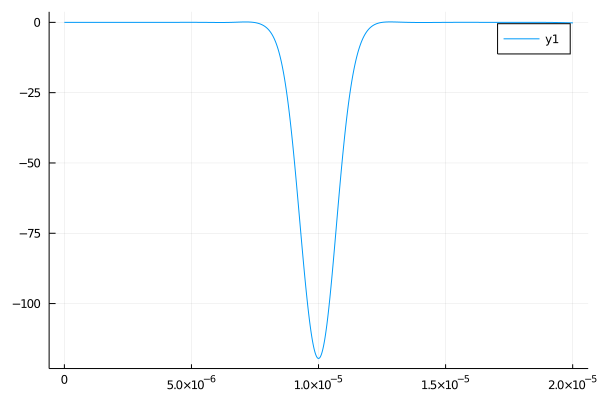

In [10]:
#plot(timestep, tout_g)
plot(timestep, tout)

In [17]:
function q(t)
    t0 = 1
    r = 0.1
    c = 1e12
    return c * exp(-(t-t0)^2 / r^2)
end
tout_g = q.(timestep * 1e5)

2001-element Array{Float64,1}:
 3.7200759760208887e-32
 3.7208200652505616e-32
 3.7223086880040565e-32
 3.7245427333101807e-32
 3.727523535812236e-32
 3.731252877090545e-32
 3.7357329874283037e-32
 3.7409665480229064e-32
 3.746956693647616e-32
 3.753707015764383e-32
 3.761221566095272e-32
 3.769504860654328e-32
 3.778561884248479e-32
 ⋮
 2.348330389857639e-30
 1.5898579986997044e-30
 1.0752962189675263e-30
 7.265542158660972e-31
 4.904305803407465e-31
 3.30716714742584e-31
 2.227939102192905e-31
 1.4994035491696873e-31
 1.008094583257523e-31
 6.770972273722614e-32
 4.543256709289263e-32
 3.045436046522662e-32

In [ ]:
out_C = run(sess, C)

In [ ]:
out_theta = run(sess, θ)

In [ ]:
run(sess, C)

In [ ]:
run(sess, θ)

In [ ]:
fc(timestep * 1e5, [20,20,1], θ; activation = "tanh")

In [ ]:
ty = Variable(TY)

In [ ]:
fc(t * 1e5, [20,20,1], temp)

In [ ]:
theta[2]

In [ ]:
temp = Variable(fc_init([1,20,20,1]))

In [ ]:
[C, θ]

In [ ]:
t

In [ ]:
out_C

In [ ]:
out_theta

In [ ]:
loss_hist

In [ ]:
fc(t * 1e5, [20,20,1], theta[2]; activation = "tanh") 

In [ ]:
t = constant(0.01)
T = ty[1]
Y = ty[2:end]
ρ = m / V # density
X = tf.reshape(ρ * tf.divide(Y, W), (N,1)) # Concentration
Q = ADCME.constant(ones(M)) # Individual progress rates
islarge = T > ADCME.constant(NASA_coeffs[:,1])
islarge = convert_to_tensor(islarge, dtype=Float64)
fhi = f_hi(NASA_coeffs, T, R)
flo = f_lo(NASA_coeffs, T, R)
cp = islarge .* fhi[:,1] + (1 - islarge) .* flo[:,1]
h = islarge .* fhi[:,2] + (1 - islarge) .* flo[:,2]
s = islarge .* fhi[:,3] + (1 - islarge) .* flo[:,3]
cvk = cp .- R
ΔS = ν' * s  # Entropy change for reaction j
ΔH = ν' * h # Entahlpy change for reaction j
####
M_t = efficiency_t' * X[:,1]
Kf_t = Af_t .* (T ^ β_t) .* exp(-E_t / (R * T)) .* M_t
Kr_t = Kf_t ./ (((pa/(R * T)) ^ sum(ν[:,tbd], dims=1)')[:,1] .* exp(ΔS[tbd] ./ R - ΔH[tbd] / (R * T)))
Qtbd =  Kf_t .* (prod(tf.pow(X, order_t), dims=1)) .- Kr_t .* (prod(tf.pow(X, ν2[:,tbd]), dims=1) .* reversible[tbd])
M_f = efficiency_f' * X[:,1]
Kf_lo = Af_lo .* (T ^ β_lo) .* exp(-E_lo / (R * T)) .* M_f
Kf_hi = Af_hi .* (T ^ β_hi) .* exp(-E_hi / (R * T)) 
Pr = Kf_lo ./ Kf_hi
Fac = ADCME.constant(ones(size(falofr)[1]))
for (i,s) in enumerate(troefall)
    a = troefall_coeff[:,i]
    fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
    c = -0.4 - 0.67 * log(fcent) / log(10)
    n = 0.75 - 1.27 * log(fcent) / log(10)
    f1 = (log(Pr[s]) / log(10) + c) / (n - 0.14 *(log(Pr[s]) / log(10) + c))
    Fac = scatter_update(Fac, troefall[i], 10 ^ ((log(fcent) / log(10)) / (1 + f1 ^ 2)))
end
Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
Kr_f = Kf_f ./ (((pa/(R * T)) ^ sum(ν[:,falofr], dims=1)')[:,1] .* exp(ΔS[falofr] ./ R - ΔH[falofr] / (R * T)))
Qfalofr = Kf_f .* (prod(tf.pow(X, order_f), dims=1)) .- Kr_f .* (prod(tf.pow(X, ν2[:,falofr]), dims=1) .* reversible[falofr])
####
#     Af = exp(θ[:,1])
#     β = zeros(M)
#     E = exp(θ[:,3])
Kf = Af .* (T ^ β) .* exp(-E / (R * T))
Kr = Kf ./ (((pa/(R * T)) ^ sum(ν[:,elmr], dims=1)')[:,1] .* exp(ΔS[elmr] ./ R - ΔH[elmr] / (R * T)))
Qelmr = Kf .* (prod(tf.pow(X, order), dims=1)) .- Kr .* (prod(tf.pow(X, ν2[:,elmr]), dims=1) .* reversible[elmr])
Q = [Qtbd' Qfalofr' Qelmr']
ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
##### Computing ω_dot 
cv = sum(cvk ./ W .* Y) # Mass heat capacities
u = h / W - R ./ W * T   # Internal energy for species
p = sum(X) * R * T # pressure
ω_dot = W .* sum(ν_new .* Q, dims=2)
###### Species Conservation
mgen_dot = V * ω_dot
Y_dot = (1 / m) * ((min_dot * (Yin - Y) - mout_dot * Y) + mgen_dot) 
###### EnergyConservation
Qdot = fc(t * 1e5, [20,20,1], θ) 
T_dot = 1 / (m * cv) * (Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))

In [ ]:
tout = fc(timestep * 1e5, [20,20,1], θ; activation = "tanh")
pred = tout * 10 ^ C
out = run(sess, pred)

In [ ]:
out = run(sess, loss)

In [ ]:
run(sess, loss)

In [ ]:
out

In [ ]:
sum((u_out[inds,1]-obs[inds,1]).^2)

In [ ]:
loss = sum((U_array[inds,1]-obs[inds,1])^2)

In [ ]:
Tt_cant

In [ ]:
u_out = run(sess, U_array)

In [ ]:
u_out

In [ ]:
run(sess, theta)

In [ ]:
Variable([0.0, 0.0])

In [ ]:
plot(log.(loss_hist))

In [ ]:
argmax(Tt)

In [ ]:
timestep[argmax(Tt[1:20000])]

In [ ]:
out

In [ ]:
nt

In [ ]:
total_heat = 0
for i = 1:nt-1
    dt = timestep[i+1] - timestep[i]
    total_heat += dt * q(timestep[i])
end

In [ ]:
nt

In [ ]:
total_heat

In [ ]:
θ = Variable(fc_init([1,20,20,1]))
#C = Variable(1.0)
#theta = Variable([8.0, 0.8])
Qdtb = fc(t * 1e5, [20,20,1], θ)

In [ ]:
sum(Qdtb)

In [ ]:
delta_t = t[2:end] - t[1:end-1]

In [ ]:
sum(Qdtb[1:end-1] * (t[2:end] - t[1:end-1]))

In [15]:
Qdot_out = run(sess, Qdot)

2001-element Array{Float64,1}:
 1.140677450529102e8
 1.1406572483030748e8
 1.1406168441959795e8
 1.140556238888945e8
 1.140475433410257e8
 1.1403744291507374e8
 1.1402532278176032e8
 1.1401118314784116e8
 1.1399502425434802e8
 1.139768463761496e8
 1.1395664982261032e8
 1.1393443493781029e8
 1.139102021001058e8
 ⋮
 1.109132197195552e9
 1.1486487086320012e9
 1.1890001972232862e9
 1.2301914666330597e9
 1.272227143990129e9
 1.3151116784361124e9
 1.3588493397620835e9
 1.4034442171254103e9
 1.4489002178588789e9
 1.495221066358255e9
 1.5424103030610294e9
 1.5904712835119534e9

In [50]:
plot(timestep, Qdot_out, label="Neural Network")
plot!(timestep, tout_g, label="Gaussian Heat Source")
xlabel!("Time (s)")
ylabel!("Heat Flux (J)")
savefig("heat_source.pdf")

In [45]:
plot((loss_hist), yaxis=:log, label = "BFGS")
xlabel!("steps")
ylabel!("loss")
savefig("loss.pdf")

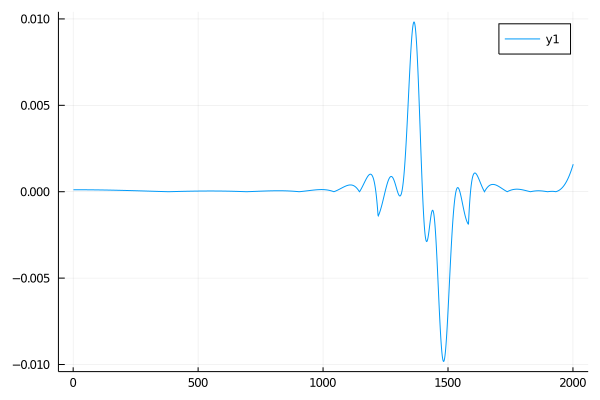

In [35]:
plot((Qdot_out .- tout_g) ./ maximum(tout_g))

In [23]:
Qdot_out

2001-element Array{Float64,1}:
 1.140677450529102e8
 1.1406572483030748e8
 1.1406168441959795e8
 1.140556238888945e8
 1.140475433410257e8
 1.1403744291507374e8
 1.1402532278176032e8
 1.1401118314784116e8
 1.1399502425434802e8
 1.139768463761496e8
 1.1395664982261032e8
 1.1393443493781029e8
 1.139102021001058e8
 ⋮
 1.109132197195552e9
 1.1486487086320012e9
 1.1890001972232862e9
 1.2301914666330597e9
 1.272227143990129e9
 1.3151116784361124e9
 1.3588493397620835e9
 1.4034442171254103e9
 1.4489002178588789e9
 1.495221066358255e9
 1.5424103030610294e9
 1.5904712835119534e9

In [24]:
tout_g

2001-element Array{Float64,1}:
 3.7200759760208887e-32
 3.7208200652505616e-32
 3.7223086880040565e-32
 3.7245427333101807e-32
 3.727523535812236e-32
 3.731252877090545e-32
 3.7357329874283037e-32
 3.7409665480229064e-32
 3.746956693647616e-32
 3.753707015764383e-32
 3.761221566095272e-32
 3.769504860654328e-32
 3.778561884248479e-32
 ⋮
 2.348330389857639e-30
 1.5898579986997044e-30
 1.0752962189675263e-30
 7.265542158660972e-31
 4.904305803407465e-31
 3.30716714742584e-31
 2.227939102192905e-31
 1.4994035491696873e-31
 1.008094583257523e-31
 6.770972273722614e-32
 4.543256709289263e-32
 3.045436046522662e-32